In [192]:
from numba import jit
import numpy as np
from numpy.random import default_rng
import pandas as pd
from typing import Union, Tuple

In [347]:
numruns = 10000
numsig = 2.0

In [355]:
rng = default_rng(12345)
vals = rng.standard_normal(numruns)
vals

array([-1.42382504,  1.26372846, -0.87066174, ...,  0.07935036,
       -0.47392947, -0.78204962])

In [356]:
df = pd.DataFrame({'x': vals})

<Axes: >

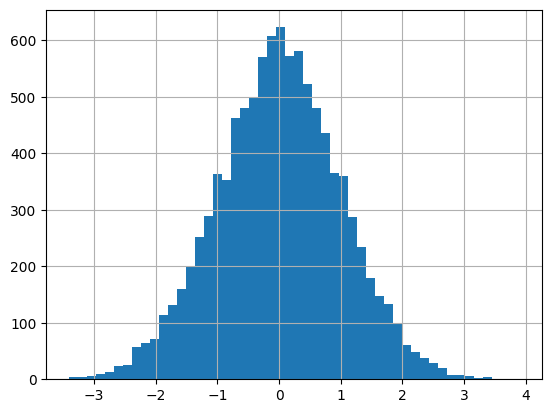

In [357]:
df.x.hist(bins=50)

In [602]:
def gwp(x_in, maxstd):
    x = x_in.copy()
    while 1:
        z = np.abs((x - np.nanmean(x)) / np.nanstd(x))
        # z = (x - np.nanmean(x)) / np.nanstd(x)
        if np.nanmax(z) > maxstd:
            imax = np.nanargmax(z)
            x[imax] = np.nan
        else:
            break
    return x

In [603]:
x2 = pd.Series(gwp(df.x, numsig))

In [604]:
x2num = x2.isna().sum()
x2num

1582

In [605]:
x2min, x2max = x2.min(), x2.max()
x2min, x2max

(-1.400321596533234, 1.4347339874790495)

<Axes: >

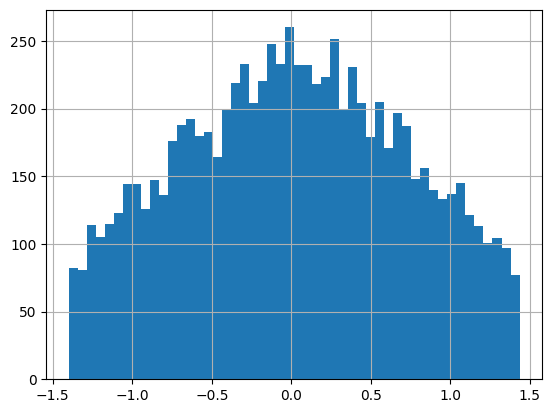

In [606]:
x2.hist(bins=50)

In [363]:
# %timeit x2 = gwp(df.x, numsig)

1.51 s ± 121 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [78]:
#@jit
def gw_main(x_in, maxstd):
    x_out = x_in.copy()
    x = np.sort(x_in) 
    eps = np.sum(x)
    nu = np.sum(np.square(x))
    maxstd2 = maxstd * maxstd
    k = len(x)
    imin = 0
    imax = k - 1
    while 1:
        xmin = x[imin]
        xmax = x[imax]
        sig2 = (1. / (k * (k - 1.))) * ((k * nu) - np.square(eps))
        z2min = np.square(xmin - (eps / k)) / sig2
        z2max = np.square(xmax - (eps / k)) / sig2
        if z2min < maxstd2 and z2max < maxstd2:
            break
        if z2min > z2max:
            xdel = xmin
            imin += 1
        else: 
            xdel = xmax
            imax -= 1
        eps -= xdel
        nu -= np.square(xdel)
        k -= 1    
    x_out[(x_out < x[imin]) | (x_out > x[imax])] = np.nan 
    return x_out 

In [79]:
def gw(x, maxstd):
    return gw_main(x.values, maxstd) 

In [80]:
nx2 = pd.Series(gw(df.x, numsig))

<Axes: >

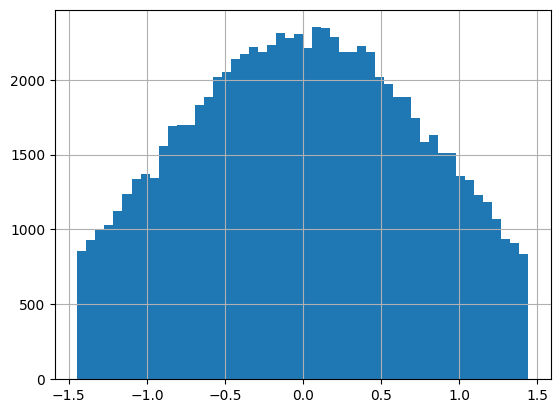

In [81]:
nx2.hist(bins=50)

In [82]:
nx2.isna().sum()

14967

In [83]:
(x2 == nx2) 

0         True
1         True
2         True
3        False
4         True
         ...  
99995     True
99996    False
99997     True
99998     True
99999     True
Length: 100000, dtype: bool

In [84]:
nx2.min(), nx2.max()

(-1.445182096904719, 1.442518376609453)

In [85]:
# %timeit nx2 = gw(df.x, numsig)

121 ms ± 2.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [86]:
@jit
def gw_main(x_in, maxstd):
    x_out = x_in.copy()
    x = np.sort(x_in) 
    eps = np.sum(x)
    nu = np.sum(np.square(x))
    maxstd2 = maxstd * maxstd
    k = len(x)
    imin = 0
    imax = k - 1
    while 1:
        xmin = x[imin]
        xmax = x[imax]
        sig2 = (1. / (k * (k - 1.))) * ((k * nu) - np.square(eps))
        z2min = np.square(xmin - (eps / k)) / sig2
        z2max = np.square(xmax - (eps / k)) / sig2
        if z2min < maxstd2 and z2max < maxstd2:
            break
        if z2min > z2max:
            xdel = xmin
            imin += 1
        else: 
            xdel = xmax
            imax -= 1
        eps -= xdel
        nu -= np.square(xdel)
        k -= 1    
    x_out[(x_out < x[imin]) | (x_out > x[imax])] = np.nan 
    return x_out 

In [87]:
def gw(x, maxstd):
    return gw_main(x.values, maxstd) 

In [88]:
nx4 = pd.Series(gw(df.x, numsig))

In [89]:
# %timeit nx6 = gw(df.x, numsig)

7.41 ms ± 67.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [440]:
@jit
def gw(x_in: np.ndarray, maxstd: Union[float, Tuple[float, float]], side: str = "both") -> np.ndarray:
    """
    Iteratively removes outliers from normally distributed input data until there are no more outliers more than maxstd standard deviations from the mean.
    Outliers are set to np.nan in the returned array.

    Args:
        x_in (numpy.ndarray): The input data.
        maxstd (Union[float, Tuple[float, float]]): The maximum number of standard deviations allowed for an outlier. If a float is given, the same maximum standard deviation is used for the upper and lower sides of the distribution. If a tuple is given and side is "both", the first value is used for the lower side and the second value is used for the upper side.
        side (str): The side(s) on which to remove outliers. Options are "lower", "upper", or "both" (default).

    Returns:
        numpy.ndarray: The input data with outliers set to np.nan.

    Notes:
        - The input data must be a 1D numpy.ndarray.
        - The function is optimized with the @jit decorator for improved performance.
    """
    if isinstance(maxstd, float):
        maxstd_upper = maxstd_lower = maxstd
    elif isinstance(maxstd, tuple) and side == "both":
        maxstd_lower, maxstd_upper = maxstd
    else:
        raise ValueError("maxstd must be a float or a tuple if side is 'both'")

    x_out = x_in.copy()
    x = np.sort(x_in)
    eps = np.sum(x)
    nu = np.sum(np.square(x))
    maxstd2_lower = maxstd_lower * maxstd_lower
    maxstd2_upper = maxstd_upper * maxstd_upper
    k = len(x)
    imin = 0
    imax = k - 1
    while 1:
        xmin = x[imin]
        xmax = x[imax]
        sig2 = (1. / (k * (k - 1.))) * ((k * nu) - np.square(eps))
        z2min = np.square(xmin - (eps / k)) / sig2
        z2max = np.square(xmax - (eps / k)) / sig2
        if side == 'both':
            if z2min < maxstd2_lower and z2max < maxstd2_upper:
                break
            if z2min < maxstd2_lower:
                xdel = xmax
                imax -= 1  
            elif z2max < maxstd2_upper:
                xdel = xmin
                imin += 1
            else:
                if z2min < z2max: 
                    xdel = xmax
                    imax -= 1
                else:
                    xdel = xmin
                    imin += 1
        elif side == "lower":
            if z2min < maxstd2_lower:
                break
            xdel = xmin
            imin += 1
        elif side == "upper":
            if z2max < maxstd2_upper:
                break
            xdel = xmax
            imax -= 1
        eps -= xdel
        nu -= np.square(xdel)
        k -= 1

    x_out[(side == "upper") & (x_out > x[imax])] = np.nan
    x_out[(side == "lower") & (x_out < x[imin])] = np.nan
    x_out[(side == "both") & ((x_out < x[imin]) | (x_out > x[imax]))] = np.nan
    return x_out

<Axes: >

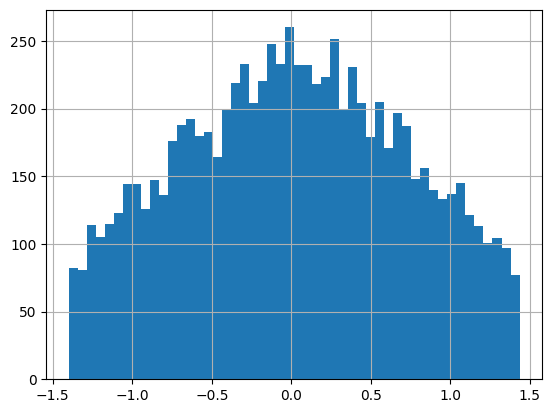

In [673]:
x8 = pd.Series(gw(df.x.values, numsig, 'both'))
x8.hist(bins=50)

In [674]:
x8num = np.sum(np.isnan(x8))
x8num, x2num

(1582, 1582)

In [675]:
x8min, x8max = np.min(x8), np.max(x8)
x8min, x8max

(-1.400321596533234, 1.4347339874790495)

In [676]:
x2min, x2max

(-1.400321596533234, 1.4347339874790495)

In [677]:
np.testing.assert_almost_equal(x8min, x2min)

In [678]:
np.testing.assert_almost_equal(x8max, x2max)

<Axes: >

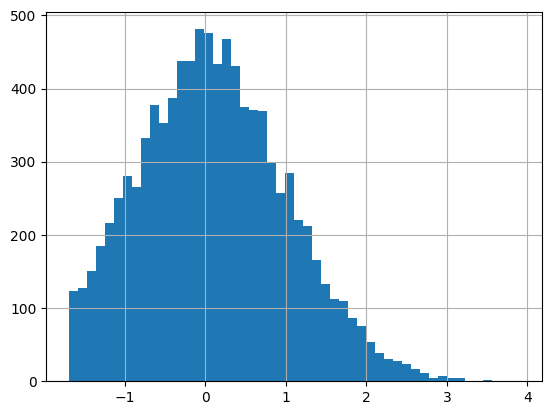

In [679]:
x8 = pd.Series(gw(df.x.values, numsig, 'lower'))
x8.hist(bins=50)

<Axes: >

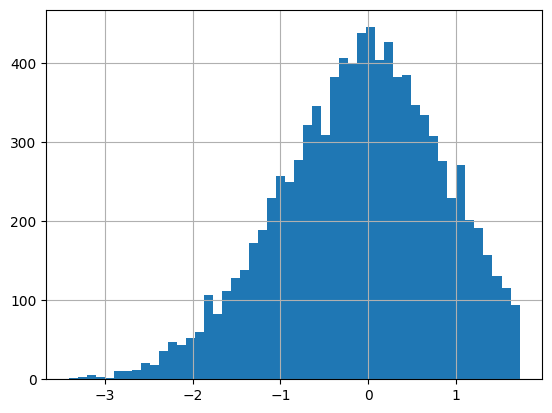

In [680]:
x8 = pd.Series(gw(df.x.values, numsig, 'upper'))
x8.hist(bins=50)

<Axes: >

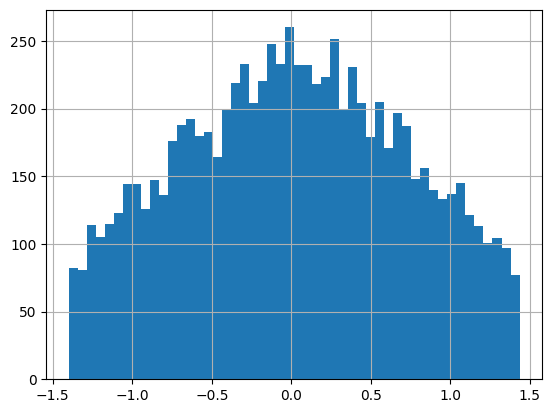

In [681]:
x8 = pd.Series(gw(df.x.values, (numsig, numsig), 'both'))
x8.hist(bins=50)

<Axes: >

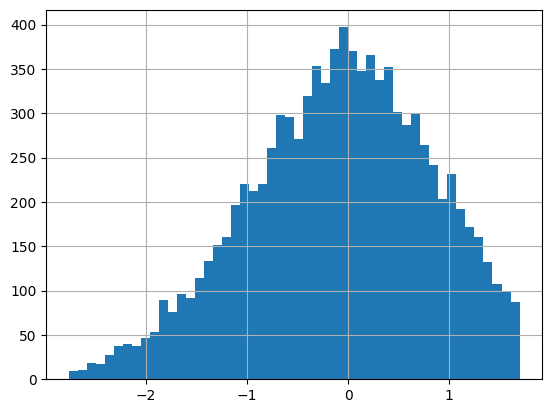

In [682]:
x8 = pd.Series(gw(df.x.values, (numsig + 1.0, numsig), 'both'))
x8.hist(bins=50)

<Axes: >

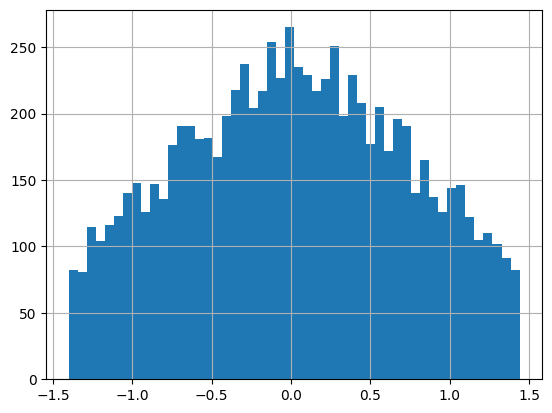

In [683]:
x8 = pd.Series(gw(df.x.values, (numsig, numsig + 1.0), 'both'))
x8.hist(bins=50)

In [671]:
@jit
def gw(x_in: np.ndarray, maxstd: Union[float, Tuple[float, float]], side: str = "both") -> np.ndarray:
    """
    Iteratively removes outliers from normally distributed input data until there are no more outliers more than maxstd standard deviations from the mean.
    Outliers are set to np.nan in the returned array.

    Args:
        x_in (numpy.ndarray): The input data.
        maxstd (Union[float, Tuple[float, float]]): The maximum number of standard deviations allowed for an outlier. If a float is given, the same maximum standard deviation is used for the upper and lower sides of the distribution. If a tuple is given and side is "both", the first value is used for the lower side and the second value is used for the upper side.
        side (str): The side(s) on which to remove outliers. Options are "lower", "upper", or "both" (default).

    Returns:
        numpy.ndarray: The input data with outliers set to np.nan.

    Notes:
        - The input data must be a 1D numpy.ndarray.
        - The function is optimized with the @jit decorator for improved performance.
    """
    if isinstance(maxstd, float):
        maxstd_upper = maxstd_lower = maxstd
    elif isinstance(maxstd, tuple) and side == "both":
        maxstd_lower, maxstd_upper = maxstd
    else:
        raise ValueError("maxstd must be a float or a tuple if side is 'both'")

    x_out = x_in.copy()
    x = np.sort(x_in)
    eps = np.sum(x)
    nu = np.sum(np.square(x))
    maxstd2_lower = maxstd_lower * maxstd_lower
    maxstd2_upper = maxstd_upper * maxstd_upper
    k = len(x)
    imin = 0
    imax = k - 1
    while 1:
        xmin = x[imin]
        xmax = x[imax]
        sig2 = (1. / (k * (k - 1.))) * ((k * nu) - np.square(eps))
        z2min = np.square(xmin - (eps / k)) / sig2
        z2max = np.square(xmax - (eps / k)) / sig2
        if side == 'both':
            if z2min < maxstd2_lower and z2max < maxstd2_upper:
                break
            if z2min > maxstd2_lower and z2min > z2max:
                xdel = xmin
                imin += 1
            else:
                xdel = xmax
                imax -= 1
        elif side == "lower":
            if z2min < maxstd2_lower:
                break
            xdel = xmin
            imin += 1
        elif side == "upper":
            if z2max < maxstd2_upper:
                break
            xdel = xmax
            imax -= 1
        eps -= xdel
        nu -= np.square(xdel)
        k -= 1

    x_out[(side == "upper") & (x_out > x[imax])] = np.nan
    x_out[(side == "lower") & (x_out < x[imin])] = np.nan
    x_out[(side == "both") & ((x_out < x[imin]) | (x_out > x[imax]))] = np.nan
    return x_out

In [658]:
# %timeit nx6 = gw(df.x.values, numsig)

663 µs ± 1.47 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


TypeError: object of type 'float' has no len()

In [672]:


@jit
def var_from_sums(eps: float, nu: float, k: int) -> float:
    """Calculate the variance of a normally distributed population given the sum of the population and the sum of the squares of the population.

    Args:
        eps (float): The sum of the population.
        nu (float): The sum of the squares of the population.
        k (int): The number of elements in the population.

    Returns
    -------
        float: The variance of the population.

    Notes
    -----
        - The function is optimized with the @jit decorator for improved performance.
    """
    return (1.0 / (k * (k - 1.0))) * ((k * nu) - (eps * eps))


@jit
def _glas_wool_side(
    x: np.ndarray, ival: int, eps: float, nu: float, maxstd2: float, k: int
) -> float:
    sgn = 1 if ival == 0 else -1
    while k > 1:
        xval = x[ival]
        z2min = np.square(xval - (eps / k)) / var_from_sums(eps, nu, k)
        if z2min < maxstd2:
            break
        ival += 1 * sgn
        eps -= xval
        nu -= xval * xval
        k -= 1
    return x[ival]


@jit
def glass_wool(
    x_in: np.ndarray, maxstd: Union[float, Tuple[float, float]], side: str = "both"
) -> np.ndarray:
    """Iteratively removes outliers from normally distributed input data until there are no more outliers more than maxstd standard deviations from the mean.
    Outliers are set to np.nan in the returned array.

    Args:
        x_in (numpy.ndarray): The input data.
        maxstd (Union[float, Tuple[float, float]]): The maximum number of standard deviations allowed for an outlier. If a float is given, the same maximum standard deviation is used for the upper and lower sides of the distribution. If a tuple is given and side is "both", the first value is used for the lower side and the second value is used for the upper side.
        side (str): The side(s) on which to remove outliers. Options are "lower", "upper", or "both" (default).

    Returns
    -------
        numpy.ndarray: The input data with outliers set to np.nan.

    Notes
    -----
        - The input data must be a 1D numpy.ndarray.
        - The function is optimized with the @jit decorator for improved performance.
    """
    if isinstance(maxstd, float):
        maxstd_upper = maxstd_lower = maxstd
    elif isinstance(maxstd, tuple) and side == "both":
        maxstd_lower, maxstd_upper = maxstd
    else:
        raise ValueError("maxstd must be a float or a tuple if side is 'both'")

    x = np.sort(x_in)
    eps = np.sum(x)
    nu = np.sum(np.square(x))
    maxstd2_lower = maxstd_lower * maxstd_lower
    maxstd2_upper = maxstd_upper * maxstd_upper
    k = len(x)
    imin = 0
    imax = k - 1

    if side == 'lower':
        xival = _glas_wool_side(x, imin, eps, nu, maxstd2_lower, k)
        x[x < xival] = np.nan
        return x
    elif side == 'upper':
        xival = _glas_wool_side(x, imax, eps, nu, maxstd2_upper, k)
        x[x > xival] = np.nan
        return x

    while k > 1:
        xmin = x[imin]
        xmax = x[imax]
        sig2 = var_from_sums(eps, nu, k)
        z2min = np.square(xmin - (eps / k)) / sig2
        z2max = np.square(xmax - (eps / k)) / sig2
        # if side == 'both':
        if z2min < maxstd2_lower and z2max < maxstd2_upper:
            break
        if z2min < maxstd2_lower:
            xdel = xmax
            imax -= 1
        elif z2max < maxstd2_upper:
            xdel = xmin
            imin += 1
        else:
            if z2min < z2max:
                xdel = xmax
                imax -= 1
            else:
                xdel = xmin
                imin += 1
        eps -= xdel
        nu -= xdel * xdel
        k -= 1

    x[(x < x[imin]) | (x > x[imax])] = np.nan
    return x